# Lorentz System

## Jax

In [3]:

# Commented out IPython magic to ensure Python compatibility.
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit, jacfwd, jacrev
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax import config
from jax import lax
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

import scipy.io
from scipy.interpolate import griddata
from scipy.linalg import lstsq
from scipy.optimize import lsq_linear
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import  least_squares

from scipy.integrate import odeint  as scipy_odeint
from mpl_toolkits.mplot3d import Axes3D

# Define the neural net
def init_layer(key, d_in, d_out):
    k1, k2 = random.split(key)
    glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
    W = glorot_stddev * random.normal(k1, (d_in, d_out))
    b = np.zeros(d_out)
    return W, b

def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


# Define the neural net
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define Fourier feature net
def MLP_FF(layers, sigma=1.0, activation=relu):
   # Define input encoding function
    def input_encoding(x, w):
        out = np.hstack([np.sin(np.dot(x, w)),
                         np.cos(np.dot(x, w))])
        return out
    freqs = sigma * random.normal(random.PRNGKey(0), (layers[0], layers[1]//2))
    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
      return params
    def apply(params, inputs):
        H = input_encoding(inputs, freqs)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    return init, apply


# Define the model
class PINN:
    def __init__(self, layers, states0, t0, t1, tol): 

        self.states0 = states0
        self.t0 = t0
        self.t1 = t1 
        
        # Grid
        n_t = 300
        eps = 0.1 * self.t1
        self.t = np.linspace(self.t0, self.t1 + eps, n_t)   

        self.M = np.triu(np.ones((n_t, n_t)), k=1).T
        self.tol = tol  

        self.rho = 28.0
        self.sigma = 10.0
        self.beta = 8.0 / 3.0

        self.init, self.apply = MLP(layers, activation=np.tanh)
        # self.init, self.apply = modified_MLP(layers, activation=np.tanh)
        params = self.init(random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=5000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)
        _, self.unravel = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
    
    def neural_net(self, params, t):
        t = np.stack([t])
        outputs = self.apply(params, t) *  t
        x = outputs[0] + self.states0[0]
        y = outputs[1] + self.states0[1]
        z = outputs[2] + self.states0[2]
        return x, y, z

    def x_fn(self, params, t):
        x, _, _ = self.neural_net(params, t)
        return x

    def y_fn(self, params, t):
        _, y, _ = self.neural_net(params, t)
        return y

    def z_fn(self, params, t):
        _, _, z = self.neural_net(params, t)
        return z

    def residual_net(self, params, t): 
        x, y, z = self.neural_net(params, t)
        x_t = grad(self.x_fn, argnums=1)(params, t)
        y_t = grad(self.y_fn, argnums=1)(params, t)
        z_t = grad(self.z_fn, argnums=1)(params, t)

        res_1 = x_t - self.sigma * (y - x)
        res_2 = y_t - x * (self.rho - z) + y
        res_3 = z_t - x * y + self.beta * z

        return res_1, res_2, res_3
 
    def loss_ics(self, params):
        # Compute forward pass
        x_pred, y_pred, z_pred =self.neural_net(params, self.t0)
        # Compute loss

        loss_x_ic = np.mean((self.states0[0] - x_pred)**2)
        loss_y_ic = np.mean((self.states0[1] - y_pred)**2)
        loss_z_ic = np.mean((self.states0[2] - z_pred)**2)
        return loss_x_ic + loss_y_ic + loss_z_ic
    
    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):
        r1_pred, r2_pred, r3_pred = vmap(self.residual_net, (None, 0))(params, self.t)
        W = lax.stop_gradient(np.exp(- tol * self.M @ (r1_pred**2 + r2_pred**2 + r3_pred**2)))
        return r1_pred, r2_pred, r3_pred, W
        
    @partial(jit, static_argnums=(0,))
    def loss_res(self, params):
        # Compute forward pass
        r1_pred, r2_pred, r3_pred, W = self.residuals_and_weights(params, self.tol)
        # Compute loss
        loss_res = np.mean(W * (r1_pred**2 +  r2_pred**2 + r3_pred**2))
        return loss_res

    @partial(jit, static_argnums=(0,))
    def loss(self, params):

        loss_res = self.loss_res(params)

        loss = loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, nIter = 10000):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_ics_value = self.loss_ics(params)
                loss_res_value = self.loss_res(params)
                _, _, _, W_value = self.residuals_and_weights(params, self.tol)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value,  
                                  'loss_res':  loss_res_value,
                                  'W_min': W_value.min()} )
                                  
                if W_value.min() > 0.99:
                    break
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_u(self, params, t_star):
        x_pred, y_pred, z_pred = vmap(self.neural_net, (None, 0))(params, t_star)
        return x_pred, y_pred, z_pred

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

state0 = [1.0, 1.0, 1.0]

T = 30
t_star = onp.arange(0, T, 0.01)
states = scipy_odeint(f, state0, t_star)

# Create PINNs model
t0 = 0.0
t1 = 0.5
tol = 0.1

tol_list = [1e-3, 1e-2, 1e-1, 1e0, 1e1]

layers = [1, 512, 512, 512, 3]

x_pred_list = []
y_pred_list = []
z_pred_list = []
params_list = []
losses_list = []

state0 = np.array([1.0, 1.0, 1.0])
t = np.arange(t0, t1, 0.01)
for k in range(int(T / t1)):
    # Initialize model
    print('Final Time: {}'.format( (k+1) * t1))
    model = PINN(layers, state0, t0, t1, tol)
    
    for tol in tol_list:
        model.tol = tol
        print('tol:', model.tol)
        # Train
        model.train(nIter=3000)
        
    params = model.get_params(model.opt_state)
    x_pred, y_pred, z_pred = model.predict_u(params, t)
    x0_pred, y0_pred, z0_pred = model.neural_net(params, model.t1)
    state0 = np.array([x0_pred, y0_pred, z0_pred])
    
    # Store predictions
    x_pred_list.append(x_pred)
    y_pred_list.append(y_pred)
    z_pred_list.append(z_pred)
    losses_list.append([model.loss_ics_log, model.loss_res_log])
    
    # Store params
    flat_params, _  = ravel_pytree(params)
    params_list.append(flat_params)
    
    np.save('x_pred_list.npy', x_pred_list)
    np.save('y_pred_list.npy', y_pred_list)
    np.save('z_pred_list.npy', z_pred_list)
    np.save('params_list.npy', params_list)
    np.save('losses_list.npy', losses_list)
    
    # Error
    t_star = onp.arange(t0, (k+1) * t1, 0.01)
    states = scipy_odeint(f, [1.0, 1.0, 1.0], t_star)
    
    x_preds = np.hstack(x_pred_list)
    y_preds = np.hstack(y_pred_list)
    z_preds = np.hstack(z_pred_list)
    
    error_x = np.linalg.norm(x_preds - states[:, 0]) / np.linalg.norm(states[:, 0]) 
    error_y = np.linalg.norm(y_preds - states[:, 1]) / np.linalg.norm(states[:, 1]) 
    error_z = np.linalg.norm(z_preds - states[:, 2]) / np.linalg.norm(states[:, 2]) 
    print('Relative l2 error x: {:.3e}'.format(error_x))
    print('Relative l2 error y: {:.3e}'.format(error_y))
    print('Relative l2 error z: {:.3e}'.format(error_z))

    
# np.save('x_pred_list.npy', x_pred_list)
# np.save('y_pred_list.npy', y_pred_list)
# np.save('z_pred_list.npy', z_pred_list)
# np.save('params_list.npy', params_list)

# x_preds = np.hstack(x_pred_list)
# y_preds = np.hstack(y_pred_list)
# z_preds = np.hstack(z_pred_list)

# error_x = np.linalg.norm(x_preds - states[:, 0]) / np.linalg.norm(states[:, 0]) 
# error_y = np.linalg.norm(y_preds - states[:, 1]) / np.linalg.norm(states[:, 1]) 
# error_z = np.linalg.norm(z_preds - states[:, 2]) / np.linalg.norm(states[:, 2]) 
# print('Relative l2 error x: {:.3e}'.format(error_x))
# print('Relative l2 error y: {:.3e}'.format(error_y))
# print('Relative l2 error z: {:.3e}'.format(error_z))





Final Time: 0.5
tol: 0.001


100%|██████████| 3000/3000 [00:04<00:00, 633.42it/s, Loss=3.412872, loss_ics=0.0, loss_res=3.412872, W_min=0.0] 


tol: 0.01


100%|██████████| 3000/3000 [00:03<00:00, 918.96it/s, Loss=3.540678, loss_ics=0.0, loss_res=3.540678, W_min=0.0]  


tol: 0.1


100%|██████████| 3000/3000 [00:03<00:00, 916.07it/s, Loss=3.0568874, loss_ics=0.0, loss_res=3.0568874, W_min=0.0]


tol: 1.0


100%|██████████| 3000/3000 [00:03<00:00, 917.70it/s, Loss=0.6490428, loss_ics=0.0, loss_res=0.6490428, W_min=0.0]           


tol: 10.0


100%|██████████| 3000/3000 [00:03<00:00, 917.04it/s, Loss=0.35722354, loss_ics=0.0, loss_res=0.35722354, W_min=0.0]


Relative l2 error x: 2.356e-03
Relative l2 error y: 1.180e-03
Relative l2 error z: 1.158e-03
Final Time: 1.0
tol: 0.001


100%|██████████| 3000/3000 [00:04<00:00, 606.88it/s, Loss=0.1235568, loss_ics=0.0, loss_res=0.1235568, W_min=0.9631061] 


tol: 0.01


100%|██████████| 3000/3000 [00:03<00:00, 917.83it/s, Loss=0.07768149, loss_ics=0.0, loss_res=0.07768149, W_min=0.7909611]


tol: 0.1


100%|██████████| 3000/3000 [00:03<00:00, 919.53it/s, Loss=0.10074845, loss_ics=0.0, loss_res=0.10074845, W_min=0.047475867]


tol: 1.0


100%|██████████| 3000/3000 [00:03<00:00, 920.13it/s, Loss=0.049730677, loss_ics=0.0, loss_res=0.049730677, W_min=3.371697e-07]


tol: 10.0


100%|██████████| 3000/3000 [00:03<00:00, 917.42it/s, Loss=0.08463045, loss_ics=0.0, loss_res=0.08463045, W_min=0.0] 


Relative l2 error x: 2.534e-03
Relative l2 error y: 1.667e-03
Relative l2 error z: 1.579e-03
Final Time: 1.5
tol: 0.001


 33%|███▎      | 1000/3000 [00:02<00:05, 335.06it/s, Loss=0.016584426, loss_ics=0.0, loss_res=0.016584426, W_min=0.9951118]


tol: 0.01


100%|██████████| 3000/3000 [00:03<00:00, 926.47it/s, Loss=0.02188847, loss_ics=0.0, loss_res=0.02188847, W_min=0.9366471]


tol: 0.1


100%|██████████| 3000/3000 [00:03<00:00, 921.30it/s, Loss=0.052885693, loss_ics=0.0, loss_res=0.052885693, W_min=0.20400451]


tol: 1.0


100%|██████████| 3000/3000 [00:03<00:00, 916.71it/s, Loss=0.02612254, loss_ics=0.0, loss_res=0.02612254, W_min=0.00040282359]


tol: 10.0


100%|██████████| 3000/3000 [00:03<00:00, 918.66it/s, Loss=0.053018373, loss_ics=0.0, loss_res=0.053018373, W_min=0.0]         


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.

In [8]:
type(model.loss_ics_log[0])

jaxlib.xla_extension.ArrayImpl

In [5]:
len(losses_list)


3

Epoch 0, Loss: 2.109052e-01
Epoch 0, Loss: 6.021491e-02


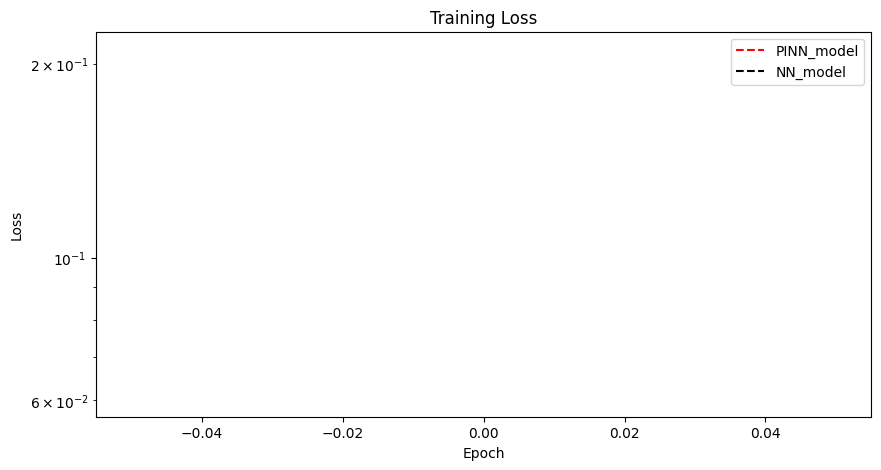

In [2]:
import os
wk_dir = os.path.abspath('')

import numpy as onp
import jax
import jax.numpy as np
from jax import random, grad, jit, vmap, jacfwd
import optax

import matplotlib.pyplot as plt

# Define data domain parameters
x0 = 0.0
x_lb = -5.0  # X lower bound
x_ub = 5.0   # X upper bound
nx = 100     # Number of points in X

t0 = 0.1     # Initial time
t1 = 0.50    # End of data domain time
t2 = 1.00    # End of physics domain time
nt = 100     # Number of points in T

n_epochs = 1  # Number of training epochs

# Exact solution function
def exact_solution(x, t):
    return np.exp(-((x - x0) ** 2) / (2 * t)) / (np.sqrt(2 * np.pi * t))

# Neural network initialization
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    params = []
    for n_in, n_out, k in zip(sizes[:-1], sizes[1:], keys):
        stddev = np.sqrt(2.0 / (n_in + n_out))
        W = stddev * random.normal(k, (n_in, n_out))
        b = np.zeros(n_out)
        params.append((W, b))
    return params

# Neural network forward pass
def neural_net(params, x):
    for W, b in params[:-1]:
        x = np.tanh(np.dot(x, W) + b)
    W, b = params[-1]
    x = np.dot(x, W) + b
    return x

# Loss function for the PINN model
def loss_fn_pinn(params, x_res, t_res, x_ic, t_ic):
    # Compute predictions
    x_t_res = np.stack([x_res, t_res], axis=1)
    p_res = neural_net(params, x_t_res).squeeze()

    x_t_ic = np.stack([x_ic, t_ic], axis=1)
    p_ic = neural_net(params, x_t_ic).squeeze()
    p_exact_ic = exact_solution(x_ic, t_ic)

    def p_single(x_t):
        return neural_net(params, x_t).squeeze()

    # Compute residuals
    dp = vmap(jacfwd(p_single))(x_t_res)
    dp_x = dp[:, 0]
    dp_t = dp[:, 1]

    dp_xx = vmap(jacfwd(lambda x_t: jacfwd(p_single)(x_t)[0]))(x_t_res)[:, 0]

    res = dp_t - 0.5 * dp_xx
    p_loss = np.mean((res) ** 2)

    # Initial condition loss
    ic_loss = np.mean((p_ic - p_exact_ic) ** 2)

    loss = p_loss + ic_loss
    return loss

# Loss function for the NN model
def loss_fn_nn(params, x_ic, t_ic):
    x_t_ic = np.stack([x_ic, t_ic], axis=1)
    p_ic = neural_net(params, x_t_ic).squeeze()
    p_exact_ic = exact_solution(x_ic, t_ic)

    # Data loss (only initial condition data)
    d_loss = np.mean((p_ic - p_exact_ic) ** 2)
    loss = d_loss
    return loss

# JIT-compiled function to compute loss and gradients for PINN
@jit
def loss_and_grads_pinn(params, x_res, t_res, x_ic, t_ic):
    loss_value, grads = jax.value_and_grad(loss_fn_pinn)(params, x_res, t_res, x_ic, t_ic)
    return loss_value, grads

# JIT-compiled function to compute loss and gradients for NN
@jit
def loss_and_grads_nn(params, x_ic, t_ic):
    loss_value, grads = jax.value_and_grad(loss_fn_nn)(params, x_ic, t_ic)
    return loss_value, grads

# Training function
def train(params, pinn, epochs, key):
    losses = []
    optimizer = optax.adam(learning_rate=0.001)
    opt_state = optimizer.init(params)

    for epoch in range(epochs):
        key, subkey1, subkey2 = random.split(key, 3)
        # Randomly sample X and T within bounds
        X = random.uniform(subkey1, shape=(nx * nt,), minval=x_lb, maxval=x_ub)
        T = random.uniform(subkey2, shape=(nx * nt,), minval=t0, maxval=t2)

        # Convert to NumPy arrays for masking
        X_np = onp.array(X)
        T_np = onp.array(T)

        # Separate data for initial condition loss (t <= t1)
        mask_ic = T_np <= t1
        X_ic = X_np[mask_ic]
        T_ic = T_np[mask_ic]

        # Convert back to JAX arrays
        X_ic = np.array(X_ic)
        T_ic = np.array(T_ic)

        if pinn:
            # Data for residual loss (entire domain)
            X_res = X
            T_res = T
            loss_value, grads = loss_and_grads_pinn(params, X_res, T_res, X_ic, T_ic)
        else:
            loss_value, grads = loss_and_grads_nn(params, X_ic, T_ic)

        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        losses.append(loss_value)
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss_value:.6e}')
    return params, losses

# Main execution
layers_sizes = [2, 64, 64, 64, 1]
key = random.PRNGKey(0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for pinn in [True, False]:
    if pinn:
        model_name = 'PINN_model'
        color = 'red'
    else:
        model_name = 'NN_model'
        color = 'black'

    key, subkey = random.split(key)
    params = init_network_params(layers_sizes, subkey)

    params, losses = train(params, pinn, n_epochs, key)
    ax.plot(losses, label=model_name, color=color, linestyle='--')

    # Optionally, save the model parameters
    # Since params is a list of (W, b), we can save it as a pickle file
    import pickle
    with open(f'{wk_dir}/{model_name}.pkl', 'wb') as f:
        pickle.dump(params, f)

plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Epoch 0, Loss: 0.035325076431035995
Epoch 1000, Loss: 0.0010236906819045544
Epoch 2000, Loss: 0.0005676232976838946
Epoch 3000, Loss: 0.00017301097977906466
Epoch 4000, Loss: 0.0008722083875909448
Epoch 0, Loss: 0.22551771998405457
Epoch 1000, Loss: 0.0003970199031755328
Epoch 2000, Loss: 0.00017082333215512335
Epoch 3000, Loss: 0.0001803875929908827
Epoch 4000, Loss: 7.045525126159191e-05


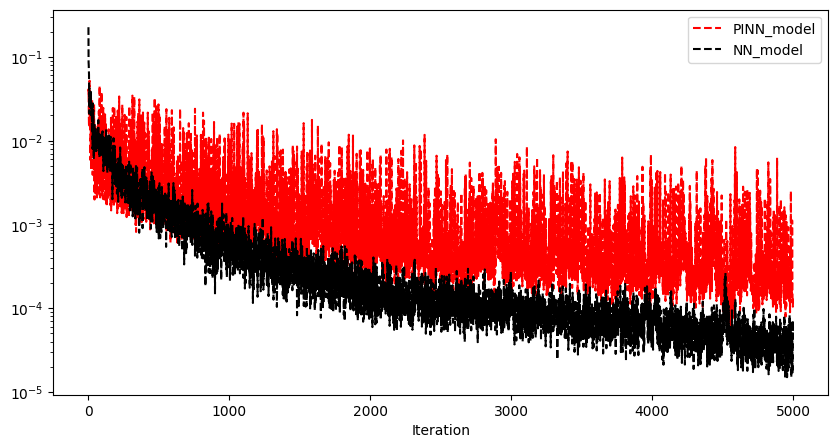

In [6]:
import os   
wk_dir =  os.path.abspath('')

import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
%matplotlib inline

def exact_solution(x, t):
    return torch.exp(-(x-x0)**2 / (2 * t)) / (torch.sqrt(2 * torch.pi * t))


class Sin(nn.Module):
    def forward(self, input: torch.Tensor, f=1.) -> torch.Tensor:
        return torch.sin(f*input)




# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, pinn=False):
        super(PINN, self).__init__()

        self.pinn = pinn

        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        x_t = torch.cat([x, t], axis=1) # Concatenate x and t
        return self.net(x_t)




# Define the loss function
def fokker_planck_loss(model, x, t):

    # define boundary points, for the boundary loss
    rshp = int(x.shape[0]**.5)

    # Autograd for computing gradients
    p = model(x, t)

    p_exact = exact_solution(x, t)

    if model.pinn:

        p_t = torch.autograd.grad(p, t, torch.ones_like(p), create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
        p_xx = torch.autograd.grad(p_x, x, torch.ones_like(p_x), create_graph=True)[0]

        # Physics loss
        
        parg = (p_t - 0.5*p_xx)**2
        w_temporal = torch.exp(-0.1*parg.reshape(rshp,rshp).sum(axis=-1)) 
        p_loss = torch.mean(parg*w_temporal)

        # Initial condition loss
        ic_loss = torch.mean((p.reshape(rshp,rshp)[:, :1] - p_exact.reshape(rshp,rshp)[:, :1])**2)
        
        

        # Boundary condition loss
        # bc_loss = torch.mean((p.reshape(rshp,rshp)[[0,-1], :] - p_exact.reshape(rshp,rshp)[[0,-1], :])**2)

        loss = p_loss + ic_loss# + bc_loss

    else:
        # data loss
        
        d_loss = torch.mean((p.reshape(rshp,rshp)[:, :50] - p_exact.reshape(rshp,rshp)[:, :50])**2)
        loss = d_loss

    return loss


# Training
def train(model, epochs, optimizer):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # randomly sample X within bounds
        # make domain data: T in [t0, t2] and X in [x_lb, x_ub]
        X = torch.Tensor(np.random.uniform(x_ub, x_lb, nx).reshape(-1, 1)).requires_grad_(True).to(device)
        T = torch.Tensor(np.random.uniform(t2, t0, nt).reshape(-1, 1)).requires_grad_(True).to(device)
        X, T = torch.meshgrid(X.squeeze(), T.squeeze())
        X = X.reshape(-1, 1).requires_grad_(True).to(device)
        T = T.reshape(-1, 1).requires_grad_(True).to(device)

        
        loss = fokker_planck_loss(model, X, T)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return losses



# define data domain
x0 = 0.
x_ub = 5 # X upper bound
x_lb = -5 # X lower bound
nx = 100 # number of points in X

t0 = 0.1 # initial time
t1 = 0.50 # end of data domain time
t2 = 1.00 # end of physics domain time
nt = 100 # number of points in T

n_epochs = 5000


fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# train the NN and PINN models
is_pinn = [True, False]
for pinn in is_pinn:

    if pinn:
        model_name = 'PINN_model'
        color = 'red'
    else:
        model_name = 'NN_model'
        color = 'black'

    # Initialize the model, optimizer, and training data
    model = PINN(pinn=pinn).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    losses = train(model, epochs=n_epochs, optimizer=optimizer)

    # Plot the loss
    ax.plot(losses, label=model_name, color=color, linestyle='--')

    torch.save(model.state_dict(), f'{wk_dir}/{model_name}.pt')

plt.legend()
plt.yscale('log')
plt.xlabel('Iteration')
plt.show()